In [146]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import pyro
import torch
import pyro.optim as optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO, Predictive, MCMC, NUTS, TracePredictive
from pyro.distributions import constraints

pyro.enable_validation(True)

# Single Level Model
In our simplest model, we will just model each post.

# Data

First, we load the Reddit datasets

In [147]:
comments = dict()
with open('../data/results/Comments.json') as f:
    for line in f:
        post = json.loads(line)
        comments[post['pid']] = post['api_num_comments'], post['comments']

In [148]:
corrections = []
with open('../data/results/CorrectionPairs.json') as f:
    for line in f:
        corrections.append(json.loads(line))

In [149]:
news = []
with open('../data/results/NewsPairs.json') as f:
    for line in f:
        news.append(json.loads(line))

Gather relevant variables

In [150]:
def processData(data, items, comments, minutes=60, offset=0):
    for idx, n in enumerate(items):
        i = idx + offset
        
        isNews = 'isFakeStory' in n['r']['reviewRating']
        news_id = n['p']['id']
        
        num_cmts, cmts = comments[news_id]
        c_body_lens = []
        c_ups = []
        c_downs = []
        unique_authors = set()
        for c in cmts:
            # skip if comment not created in first _ mins
            if c['delta_seconds'] > minutes * 60:
                continue

            c_minutes = c['delta_seconds'] / 60
            if c_minutes <= minutes:   # cmts in first _ mins
                data[i, 7] += 1
            
            c_body_lens.append(c['body_len'])
            c_ups.append(c['ups'])
            c_downs.append(c['downs'])
            
            if c['author']:
                unique_authors.add(c['author'])

        data[i, 0] = num_cmts
        if isNews:
            data[i, 1] = 1 if n['r']['reviewRating']['isFakeStory'] else 0
        else:
            data[i, 1] = 3 if n['r']['reviewRating']['isFakeClaim'] else 2
        data[i, 2] = np.mean(c_body_lens) if c_body_lens else 0.
        data[i, 3] = np.std(c_body_lens) if c_body_lens else 0.
        data[i, 4] = np.mean(c_ups) if c_ups else 0.
        data[i, 5] = np.std(c_ups) if c_ups else 0.
        data[i, 6] = len(unique_authors) if unique_authors else 0.
    return data

In [151]:
num_p_indep = 8
data = np.zeros((len(news) + len(corrections), num_p_indep))

data = processData(data, news, comments)
data = processData(data, corrections, comments, offset=len(news))

Variables (in order):

0. num_comments
1. type
2. comment_length_avg
3. comment_length_std
4. comment_upvotes_avg
5. comment_upvotes_std
6. num_unique_comment_authors
7. num_comments in first _ mins

In [152]:
# select relevant indep vars
# p_data = data[:, (2,4,6,7)]  # avg cmt length, avg upvotes, num authors, num initial comments
p_data = data[:,7].reshape(-1,1)  # num comments in 1st hr
t_data = data[:,1].reshape(-1,1)

# add bias terms
biases = np.ones_like(t_data)
p_data = np.concatenate((biases, p_data), axis=1)
t_data = np.concatenate((biases, t_data), axis=1)

# get dep var
y = data[:,0].reshape(-1,1) + 1

split into train/test

In [153]:
np.random.seed(0)

train_frac = 0.7
num_obs = p_data.shape[0]
idx = np.random.binomial(1, train_frac, size=num_obs).astype(bool)

p_data_train = p_data[idx,:]
p_data_test = p_data[~idx,:]

y_train = y[idx,:]
y_test = y[~idx,:]

-----

# Modeling

Cast data to torch tensors

In [154]:
p_data_train = torch.Tensor(p_data_train)
p_data_test = torch.Tensor(p_data_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

Post-Level Regression

y_p = phi_0 * bias + phi_1 * first_hour_comments + epsilon

In [161]:
def model_no_subsample(p_data, y):
    num_posts, num_p_indeps = p_data.shape

    # define a prior for our regression variables
    phi_loc = torch.zeros((num_p_indeps))  # (num_p_indeps,)
    phi_scale = 0.01 * torch.ones((num_p_indeps))  # (num_p_indeps,)
    
    with pyro.plate("p_indep", num_p_indeps, dim=-1) as pi:
        phi = pyro.sample("phi", dist.Normal(phi_loc, phi_scale))  # (num_p_indeps,)

    # for each post, use the correct set of coefficients to run our post-level regression
    with pyro.plate("post", size=num_posts) as p:

        # indep vars for this post
        indeps = p_data[p,:]  # (num_posts, num_p_indeps)
        
        # calculate the mean
        mu = torch.matmul(indeps, phi.reshape((-1,1))).flatten()  # (num_posts, num_p_indeps) (num_p_indeps, 1)
        
        # sample
        if y is not None:
            return pyro.sample("obs", dist.Pareto(torch.ones((num_posts,)) - 1e-3, torch.nn.ReLU()(mu)), obs=y[p,0])  # (num_posts_sub, 1)
        else:
            return pyro.sample("obs", dist.Pareto(torch.ones((num_posts,)) - 1e-3, torch.nn.ReLU()(mu)), obs=y)  # (num_posts_sub, 1)
    

In [162]:
def model(p_data, y):
    num_posts, num_p_indeps = p_data.shape

    # define a prior for our regression variables
    phi_loc = torch.zeros((num_p_indeps))  # (num_p_indeps,)
    phi_scale = 0.01 * torch.ones((num_p_indeps))  # (num_p_indeps,)
    
    with pyro.plate("p_indep", num_p_indeps, dim=-1) as pi:
        phi = pyro.sample("phi", dist.Normal(phi_loc, phi_scale))  # (num_p_indeps,)

    subsample_size=100
    # for each post, use the correct set of coefficients to run our post-level regression
    with pyro.plate("post", size=num_posts, subsample_size=subsample_size) as p:
        
        # indep vars for this post
        indeps = p_data[p,:]  # (num_posts_sub, num_p_indeps)
        
        # calculate the mean
        mu = torch.matmul(indeps, phi.reshape((-1,1))).flatten()  # (num_posts_sub, num_p_indeps) (num_p_indeps, 1)
        print(indeps.shape)
        print(phi.shape)
#         lmda = torch.prod(torch.exp(indeps * phi.T), dim=1)
        
        # sample
        if y is not None:
            return pyro.sample("obs", dist.Pareto(torch.ones((subsample_size,)) - 1e-3, torch.nn.ReLU()(mu)), obs=y[p,0])  # (num_posts_sub, 1)
        else:
            return pyro.sample("obs", dist.Pareto(torch.ones((subsample_size,)) - 1e-3, torch.nn.ReLU()(mu)), obs=y)  # (num_posts_sub, 1)
        
        

In [163]:
def guide(p_data, y):
    num_posts, num_p_indeps = p_data.shape
    
    # define a prior for our regression variables
    phi_loc = pyro.param("phi_loc", torch.zeros((num_p_indeps)))  # (num_p_indeps,)
    phi_scale = pyro.param("phi_scale", 0.01 * torch.ones((num_p_indeps)),  # (num_p_indeps,)
                              constraint=constraints.positive)
    
    with pyro.plate("p_indep", num_p_indeps, dim=-1) as pi:
        phi = pyro.sample("phi", dist.Normal(phi_loc, phi_scale))  # (num_p_indeps,)
    return phi

In [164]:
a = torch.Tensor([[1, 2],
                  [3, 4]]) # (2, 2)
b = torch.Tensor([[5], [10]]) # (2, 1)

torch.exp(a * b)



tensor([[1.4841e+02, 2.2026e+04],
        [1.0686e+13, 2.3539e+17]])

In [165]:
torch.prod(torch.exp(a * b), dim=1)

tensor([3.2690e+06, 2.5154e+30])

---

# Inference

## SVI

In [166]:
SUBSET_DATA = False

svi = SVI(model,
          guide,
          optim.Adam({"lr": .1}),
          loss=JitTrace_ELBO())

pyro.clear_param_store()
num_iters = 10000
losses = np.zeros((num_iters,))
for i in range(num_iters):
    if SUBSET_DATA:
        elbo = svi.step(p_data_train[:100], y_train[:100])
    else:
        elbo = svi.step(p_data_train, y_train)
#     print(elbo)
    losses[i] = elbo

torch.Size([100, 2])
torch.Size([2])


ValueError: The parameter rate has invalid values
Trace Shapes:      
 Param Sites:      
Sample Sites:      
 p_indep dist     |
        value   2 |
     phi dist   2 |
        value   2 |
    post dist     |
        value 100 |

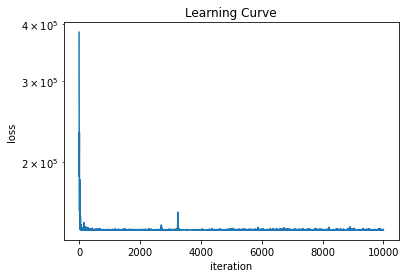

In [65]:
plt.plot(range(len(losses)), np.array(losses))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale("log")
plt.title("Learning Curve")
plt.show()

Get samples from posterior (and calculate fitted params)

In [67]:
num_samples = 1000
svi_phi_posterior_samples = np.empty((2, num_samples))
svi_sigma_posterior_samples = np.empty((num_samples, 1))

for i in range(num_samples):
    phi = guide(p_data_train[:100], y_train[:100])
    svi_phi_posterior_samples[:,i] = phi.detach().numpy().flatten()
    
svi_phi_posterior = svi_phi_posterior_samples.mean(axis=1)

print(svi_phi_posterior)

[1.66546962 0.17068782]


Get fitted params (last estimate from training?)

In [69]:
svi_phi_loc = pyro.param('phi_loc').detach().numpy().flatten()
svi_phi_scale = pyro.param('phi_scale').detach().numpy().flatten()

In [70]:
print("phi_loc\t\t", svi_phi_loc[0], svi_phi_loc[1])
print("phi_scale\t", svi_phi_scale[0], svi_phi_scale[1])

phi_loc		 1.6656251 0.17068434
phi_scale	 0.0023125862 0.0001287159


Get posterior predictive samples

In [71]:
num_samples = 1000
svi_predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape((1,num_samples,-1)).detach().cpu().numpy()
               for k, v in svi_predictive(p_data_test, None).items()
               if k != 'obs'}

torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])


torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])


torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])


torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])


torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])
torch.Size([100, 2])
torch.Size([2, 1])


In [72]:
svi_samples['phi'].mean(axis=1)

array([[1.6656147 , 0.17068689]], dtype=float32)

## MCMC (NUTS)

In [167]:
kernel = NUTS(model_no_subsample, target_accept_prob=0.8, adapt_step_size=True)

num_iters = 1000
warmup_steps = 1000
mcmc = MCMC(kernel, num_samples=num_iters, warmup_steps=warmup_steps)
mcmc.run(p_data_train[:100], y_train[:100])

Sample: 100%|██████████| 2000/2000 [01:07, 29.65it/s, step size=4.55e-01, acc. prob=0.935]


In [168]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    phi[0]      0.09      0.01      0.09      0.08      0.11    520.71      1.00
    phi[1]      0.01      0.01      0.01     -0.00      0.02    356.13      1.00

Number of divergences: 30


Get samples from posterior (and manually calculate fitted params)

In [169]:
mcmc_posterior_samples = mcmc.get_samples()

In [170]:
mcmc_phi_loc = mcmc_posterior_samples["phi"].detach().numpy().mean(axis=0).flatten()
mcmc_phi_scale = mcmc_posterior_samples["phi"].detach().numpy().std(axis=0).flatten()

In [171]:
print("phi_loc\t\t", mcmc_phi_loc[0], mcmc_phi_loc[1])
print("phi_scale\t", mcmc_phi_scale[0], mcmc_phi_scale[1])

phi_loc		 0.0949346 0.007912617
phi_scale	 0.006907683 0.005896952


Get posterior predictive samples

In [172]:
mcmc_predictive = Predictive(model=model_no_subsample, 
                             posterior_samples=mcmc_posterior_samples)

note: mcmc_predictive is slow when applied to large datasets (capping to 1k test obs here)

In [173]:
num_samples=1000
mcmc_samples = {k: v.reshape((1,num_samples,-1)).detach().cpu().numpy()
               for k, v in mcmc_predictive(p_data_test[:1000], None).items()}

ValueError: The parameter rate has invalid values
Trace Shapes:       
 Param Sites:       
Sample Sites:       
 p_indep dist      |
        value    2 |
     phi dist    2 |
        value    2 |
    post dist      |
        value 1000 |

In [174]:
mcmc_samples

{'obs': array([[[ 7.063785 ,  1.3745092,  1.3772583, ...,  2.0620704,
           1.2962682,  4.945167 ],
         [ 8.068049 ,  1.0220073, 11.037865 , ...,  1.969129 ,
           2.766445 , 54.752384 ],
         [ 4.786038 ,  1.4631318,  2.3014681, ...,  5.256558 ,
           1.2248317,  2.5576413],
         ...,
         [ 2.7898262,  4.029527 , 10.071344 , ...,  1.0697527,
           1.8845668,  4.2542734],
         [ 1.6589316,  1.2653705,  1.2863361, ..., 11.258352 ,
           2.8595614,  5.9579887],
         [ 2.8112214,  1.0516212,  1.1964765, ...,  5.3581533,
           1.4232634, 21.534264 ]]], dtype=float32)}

In [175]:
phi_means = mcmc_posterior_samples["phi"].mean(dim=0)
phi_means

tensor([0.0949, 0.0079])

returns only obs? svi returns obs and params

---

# Evaluation

Check the fit

In [176]:
xmin = float(p_data_train[:100,1].min())
xmax = float(p_data_train[:100,1].max())

xs = np.linspace(xmin, xmax, num=100)

<ipython-input-178-131a1e771f9a>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coefs = torch.tensor(phi_loc) # (num_p_indeps,num_posts)
<ipython-input-178-131a1e771f9a>:49: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(p_data[:,indep]), np.log(y), alpha=0.5, s=12, c=color, label=f"Actual")
<ipython-input-178-131a1e771f9a>:50: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(p_data[:,indep]), np.log(y_pred), c=color, label=f"Predicted")


(100,)
(21830, 1)


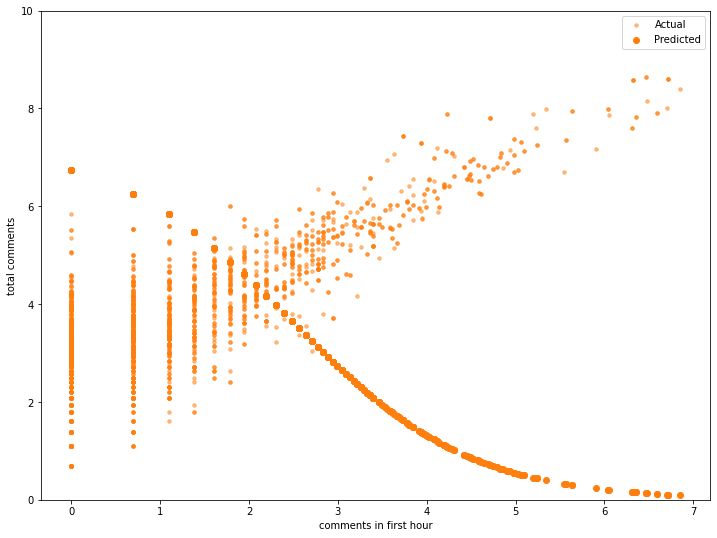

In [178]:
indep = 1 

# indep_dict = {
#     1: "avg cmt length",
#     2: "avg upvotes",
#     3: "num authors",
#     4: "comments in first hour",
# }
indep_dict = {
    1: "comments in first hour",
}

use_MCMC = True

if use_MCMC:
    phi_loc = phi_means
else:
    phi_loc = pyro.param('phi_loc').detach()

# eta_loc = torch.Tensor([[ 0.2019, -0.0130,  0.1875],
#                         [ 0.3866, -0.6894,  0.0956]]

indeps = torch.tensor(p_data)

coefs = torch.tensor(phi_loc) # (num_p_indeps,num_posts)

alpha = torch.nn.ReLU()(torch.matmul(indeps, coefs.reshape(-1,1).type(torch.DoubleTensor)))

y_pred = np.power(2., 1. / np.array(alpha)).reshape((-1,1))





# y_pred_mcmc = float(phi_means[0])
# y_pred_mcmc += float(phi_means[1]) * p_data[:,indep]


plt.figure(figsize=(12,9))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_choices = np.random.choice(colors, size=1, replace=False)


print(p_data[:100,indep].shape)
print(y_pred.shape)

color = color_choices[0]
plt.scatter(np.log(p_data[:,indep]), np.log(y), alpha=0.5, s=12, c=color, label=f"Actual")
plt.scatter(np.log(p_data[:,indep]), np.log(y_pred), c=color, label=f"Predicted")
    
# plt.plot(np.array(p_data[:,indep]), np.array(y_pred_mcmc), c='tab:green', label=f'MCMC: {phi_means[0]}, {phi_means[1]}') # MCMC
plt.xlabel(indep_dict[indep])
plt.ylabel('total comments')
plt.legend()
plt.ylim(0,10)
plt.show()

In [137]:
print(indeps.shape)
print(coefs.reshape(-1,1).shape)
alpha = torch.exp(torch.matmul(indeps, coefs.reshape(-1,1).type(torch.DoubleTensor)))

torch.Size([21830, 2])
torch.Size([2, 1])


In [133]:
indep = 1

indep_dict = {
    1: "comments in first hour",
}

# svi
y_pred_svi = svi_phi_loc[0]
y_pred_svi += svi_phi_loc[1] * p_data_train[:100,indep].detach().numpy()
y_pred_svi = np.exp(y_pred_svi)

y_reg_svi = svi_phi_loc[0]
y_reg_svi += svi_phi_loc[1] * xs
y_reg_svi = np.exp(y_reg_svi)

# mcmc
y_pred_mcmc = mcmc_phi_loc[0]
y_pred_mcmc += mcmc_phi_loc[1] * p_data_train[:100,indep].detach().numpy()
y_pred_mcmc = np.exp(y_pred_mcmc)

y_reg_mcmc = mcmc_phi_loc[0]
y_reg_mcmc += mcmc_phi_loc[1] * xs
y_reg_mcmc = np.exp(y_reg_mcmc)

NameError: name 'svi_phi_loc' is not defined

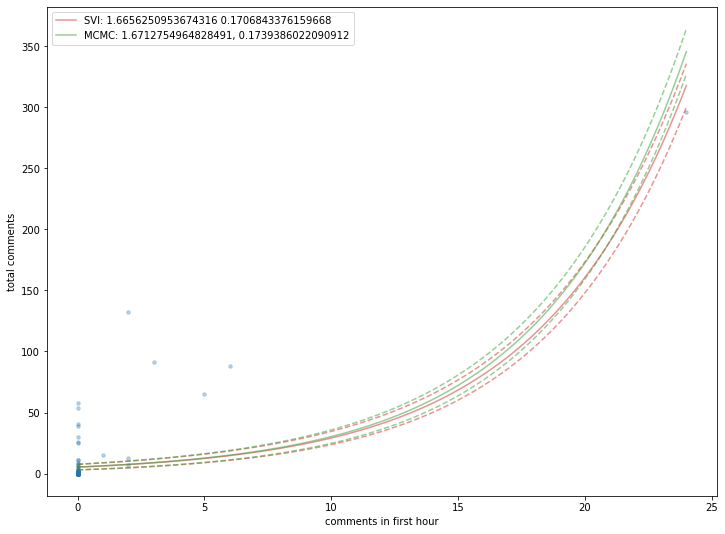

In [89]:
plt.figure(figsize=(12,9))
plt.scatter(np.array(p_data_train[:100,indep]), np.array(y_train[:100]), alpha=0.3, s=12, c='tab:blue')

plt.plot(xs, np.array(y_reg_svi), alpha=0.5, c='tab:red', label=f'SVI: {svi_phi_loc[0]} {svi_phi_loc[1]}') # SVI
plt.plot(xs, np.array(y_reg_svi)+np.sqrt(y_reg_svi), '--', alpha=0.5, c='tab:red')
plt.plot(xs, np.array(y_reg_svi)-np.sqrt(y_reg_svi), '--', alpha=0.5, c='tab:red')

plt.plot(xs, np.array(y_reg_mcmc), alpha=0.5, c='tab:green', label=f'MCMC: {mcmc_phi_loc[0]}, {mcmc_phi_loc[1]}') # MCMC
plt.plot(xs, np.array(y_reg_mcmc)+np.sqrt(y_reg_mcmc), '--', alpha=0.5, c='tab:green')
plt.plot(xs, np.array(y_reg_mcmc)-np.sqrt(y_reg_mcmc), '--', alpha=0.5, c='tab:green')

plt.xlabel(indep_dict[indep])
plt.ylabel('total comments')
plt.legend()
plt.show()

Interpretation:

- For posts with no comments in the first hour, we expect 5 comments in total
- For every comment in the first hour, we expect an additional 10 comments in total

Check residuals (diff between predicted comments and actual comments)

In [90]:
residual_svi = np.abs(y_train[:100].detach().numpy().reshape(-1,) - y_pred_svi)
residual_mcmc = np.abs(y_train[:100].detach().numpy().reshape(-1,) - y_pred_mcmc)

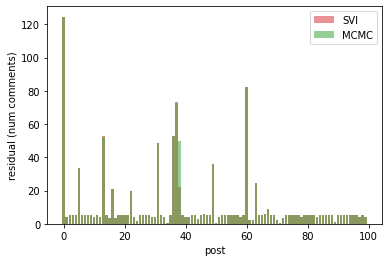

In [93]:
plt.bar(range(len(residual_svi)), residual_svi, alpha=0.5, color='tab:red', label='SVI')
plt.bar(range(len(residual_mcmc)), residual_mcmc, alpha=0.5, color='tab:green', label='MCMC')
plt.ylabel('residual (num comments)')
plt.xlabel('post')
plt.legend()
plt.show()

## Arviz plots

Estimated posterior distribution

/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/venv/lib/python3.8/site-packages/arviz/data/io_pyro.py:152: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


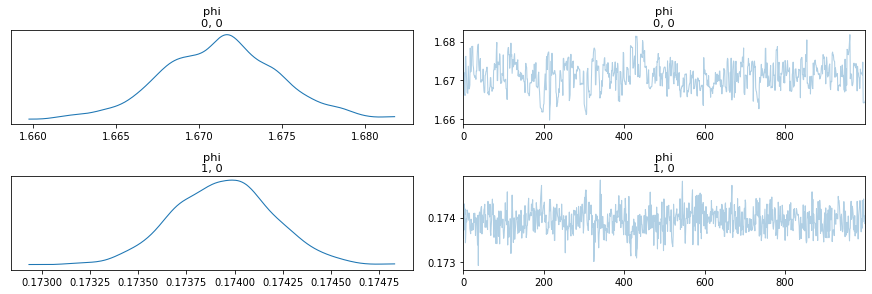

In [94]:
mcmc_data = az.from_pyro(mcmc)
az.plot_trace(mcmc_data, compact=False);

Posterior predictive distribution

In [95]:
#mcmc_data = az.convert_to_inference_data(mcmc_samples)
#az.plot_trace(mcmc_data, compact=False);

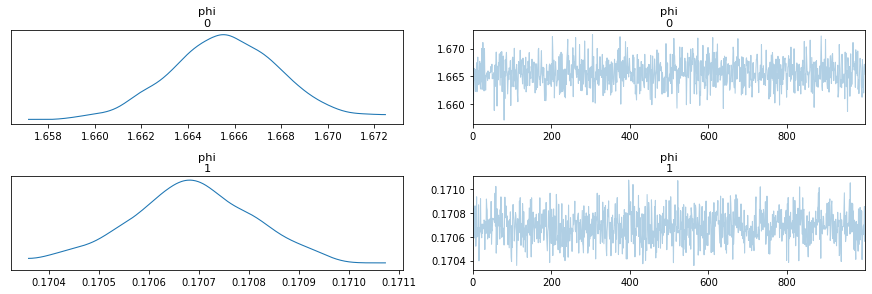

In [96]:
svi_data = az.convert_to_inference_data(svi_samples)
az.plot_trace(svi_data, compact=False);

other evaluation plots (only using svi here)

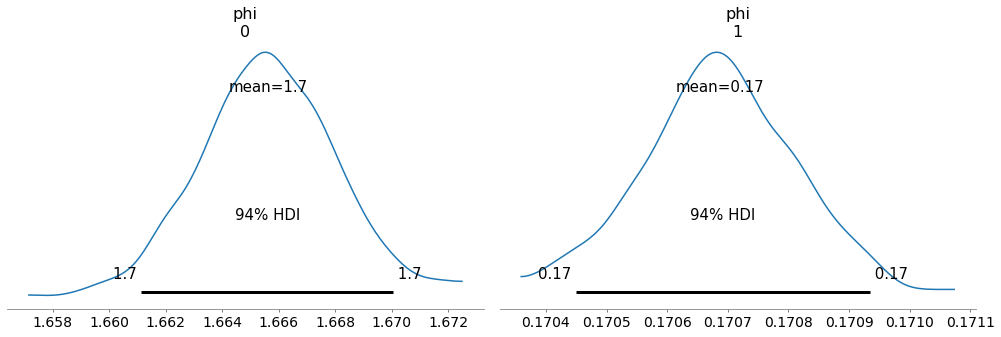

In [97]:
az.plot_posterior(svi_data)
plt.show()

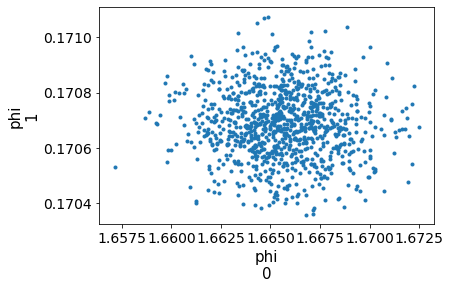

In [98]:
az.plot_pair(svi_data)
plt.show()

---